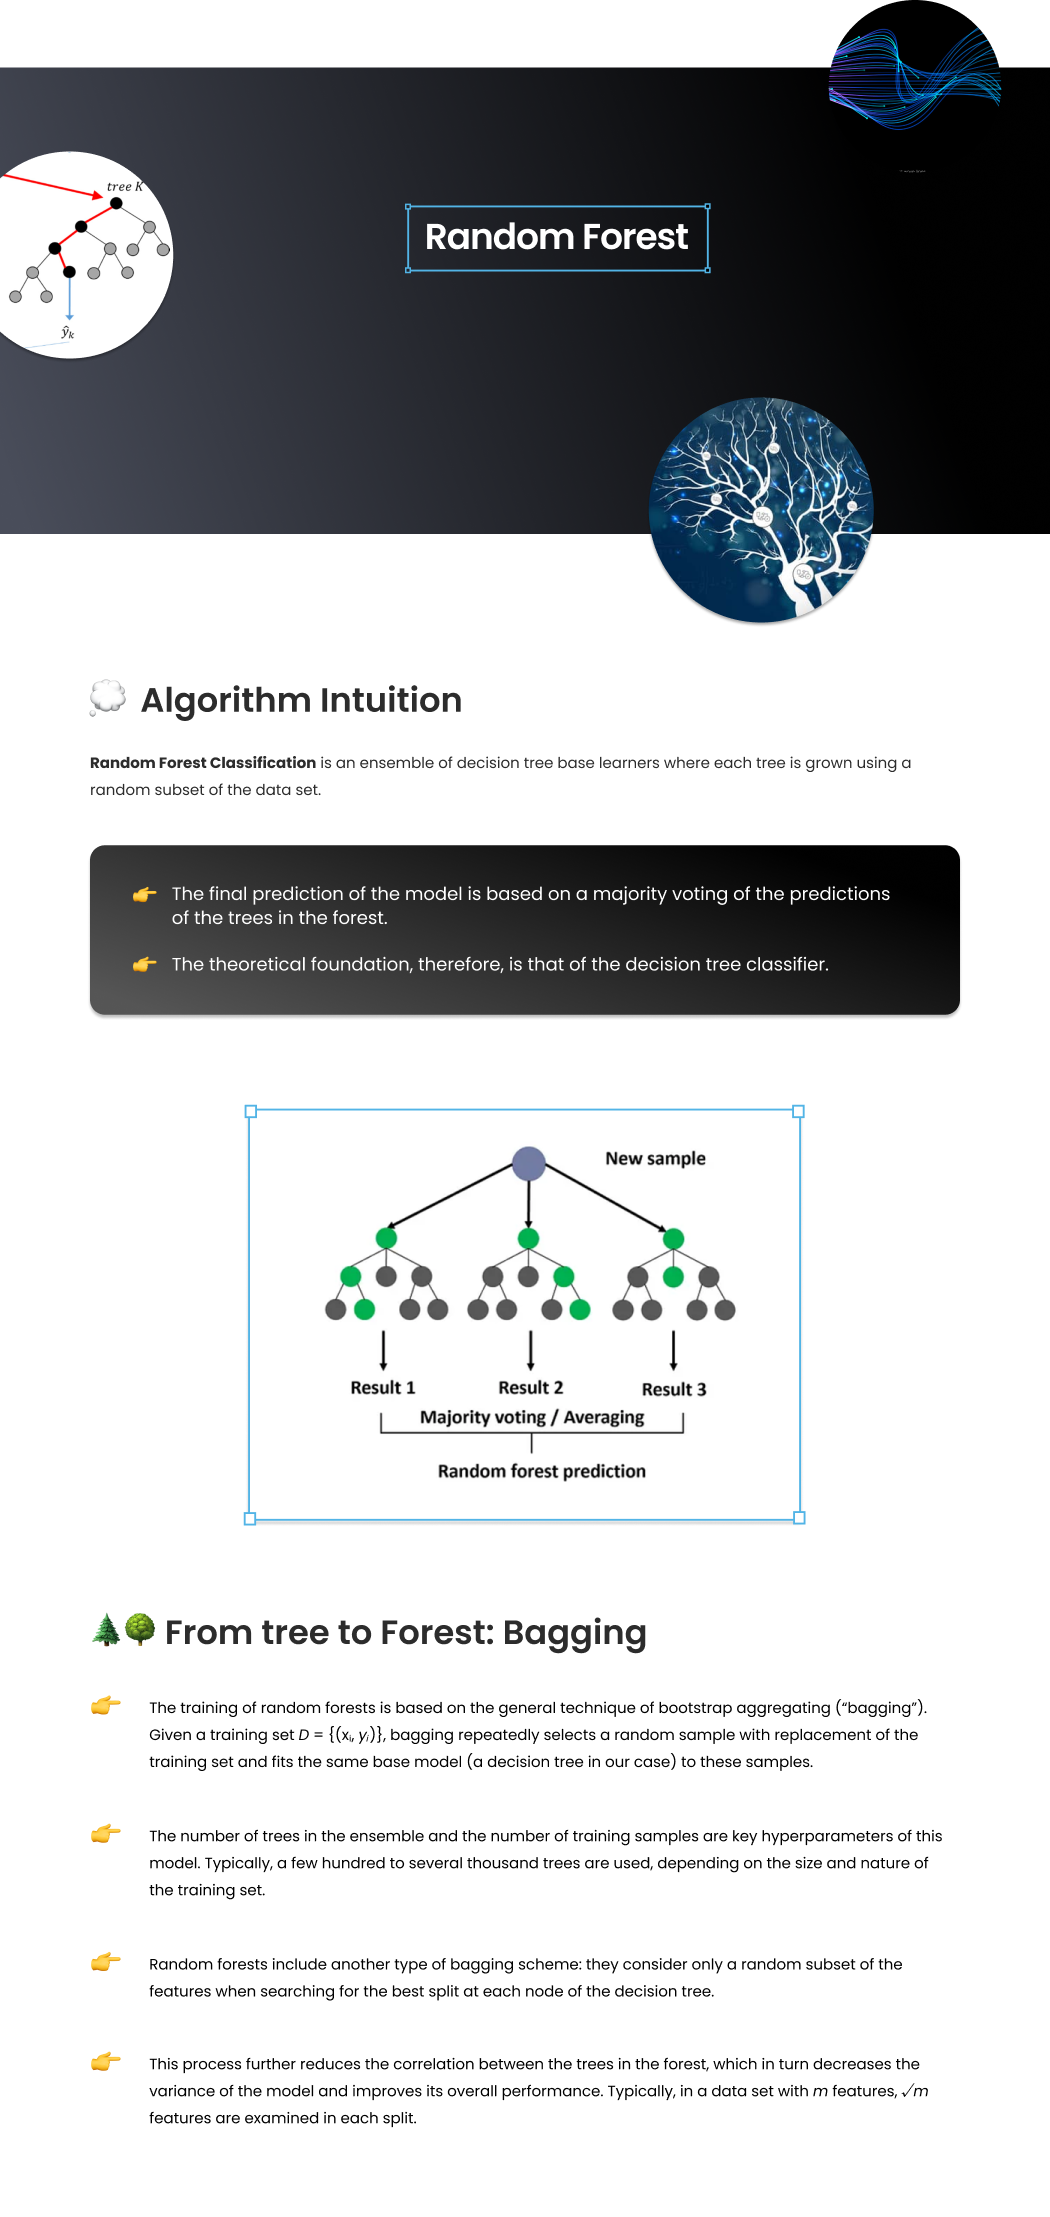

In [25]:
from IPython.display import Image
Image("images\Figma_Random_Forest.png")

*Approach*
1. Load data
2. Split data
3. Create ColumnTransformer w/ ohe (so scaling needed)
4. Create RandomForestClassifier w/ default
5. Create pipeline w/ ColumnTransformer & RandomForestClassifier
6. Create and evaluate cross_val_score on pipeline
7. Compare train and test scores for baseline model (overfitting? Train likely ~ 100%)
8. Visualise affect of different seeds on baseline model.
9. Create GridSearchCV with params 
10. Fit and evaluate best hyperparameters
11. Plot classification_report and confusion_matrix
12. Evaluate affect of balancing the class with smote or with class_weight="balanced"
13. ????Visualise the best performing model with sklearn.tree.plot_tree 
14. Select k most important features and evaluate re-run with just those


*Import Libraries*

In [2]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Import data from initial EDA*

In [3]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [4]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# # check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [5]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [6]:
# create model
model_rf = RandomForestClassifier(random_state=42)  
                                                    # n_estimators = 100 [int]
                                                    # criterion ='gini' ["gini", "entropy", "log_loss"]
                                                    # splitter = 'best' ["best", "random"]
                                                    # max_depth = None [int]
                                                    # min_samples_split = 2 [int or float]
                                                    # min_samples_leaf = 1 [int or float]
                                                    # min_weight_fraction_leaf = 0.0 [float]
                                                    # max_features = "sqrt" [int or float or "auto", "sqrt", "log2"]
                                                    # --> random_state = None
                                                    # max_leaf_nodes = None [int]
                                                    # min_impurity_decrease = 0.0 [float]
                                                    # class_weight = None [dict, list of dict or "balanced"]
                                                    # ccp_alpha = 0.0 [float]
                                                    # max_samples = None [int]

# create sklearn pipeline
pipeline_rf = settings.create_pipeline(["preprocess", column_trans], ["decision_tree_classification", model_rf])

# create cross validation object for cross_val_score
cv_rf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define custom scorer for this work: positive label (class 1 and 2) F1 score
base_scorer = settings.CustomPositiveF1Scorer().scorer_function
custom_scorer = settings.CustomPositiveF1Scorer().custom_scorer

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_rf, X_train, y_train, scoring=custom_scorer, cv=cv_rf)

settings.cross_val_summary(pipeline_rf, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 90.100 %
Mean CV Train Score: 81.2000 % ( +- 4.800 % )
Test Score: 82.100 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        66
           1       0.83      0.79      0.81        24
           2       0.80      0.87      0.83        23

    accuracy                           0.91       113
   macro avg       0.87      0.88      0.87       113
weighted avg       0.91      0.91      0.91       113



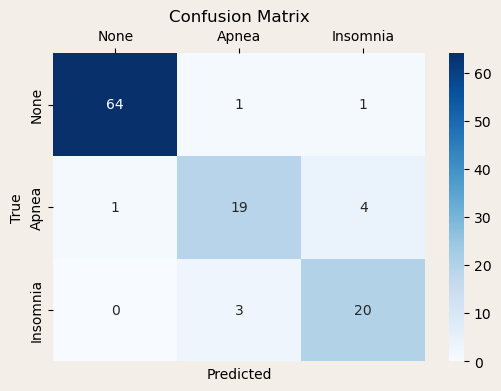

In [8]:
pipeline_rf.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_rf.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Decent baseline cross validated F1 score 81.2% and slightly higher test accuracy 82.1%. Both far below train accuracy at 90.1%: sign of overfitting.</li>
    <li>High variation (slightly lower than other base models) in cross validated scores (4.8%)</li>
    <li>Overall model accuracy is high at ~ 91%.</li>
    <li>The model is struggling more than others to separate the positive classes at the baseline stage: model making more mistakes at misclassifying Apnea like the decision tree. Let's see if tuning can move some of the misclassifications in to their correct label (recall) without comprimising (class accuracy) precisoin further.
</ul>
</div>


In [9]:
# Save baseline pipeline to file  
settings.save_pipeline("best_random_forest_classification_pipeline.pkl", pipeline_rf)

*Hyperparam tuning*

*Impurity and split method*

In [ ]:
# set up param grid
param_grid_rf = {
    'decision_tree_classification__n_estimators': [10, 50, 100, 200, 500],
    'decision_tree_classification__max_depth': np.arange(3, 11),
    'decision_tree_classification__max_samples': np.arange(0.5, 1.0, 0.1),
    'decision_tree_classification__max_features': ['sqrt', 'log2', None], 
}

# Create and fit GridSearchCV object on train data
grid_search_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, scoring=custom_scorer, cv=cv_rf, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

In [11]:
settings.hyperparam_tune_summary(grid_search_rf, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,decision_tree_classification__max_depth,decision_tree_classification__max_features,decision_tree_classification__max_samples,decision_tree_classification__n_estimators
0,4,sqrt,0.5,10


---------------------
Using best parameters
---------------------
Train Score: 86.400 %
Mean CV Train Score: 83.200 % ( +- 5.300 % )
Test Score: 86.300 %


*Review metrics for hypertuned model*

Test Accuracy: 92.900 %

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        66
           1       0.79      0.92      0.85        24
           2       0.95      0.83      0.88        23

    accuracy                           0.93       113
   macro avg       0.91      0.90      0.90       113
weighted avg       0.94      0.93      0.93       113



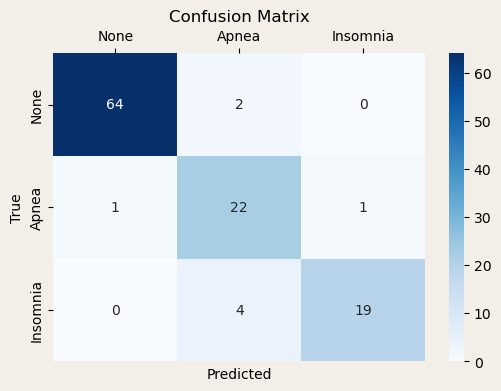

In [12]:
# Print test accuracy
pipeline_rf = grid_search_rf.best_estimator_
test_accuracy = pipeline_rf.score(X_test, y_test)
print('Test Accuracy:', settings.score_formatter(test_accuracy, 3))

# Generate prediction and show classification report
y_pred = pipeline_rf.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Cross validated and Test F1 score have both improved 2-4% following tuning.</li> 
    <li>Confusion matrix shows same state as Decision Tree.</li>
</ul>
</div>


In [13]:
# Save baseline pipeline to file  
settings.save_pipeline("best_random_forest_classification_pipeline.pkl", pipeline_rf)

*Exploring hyperparameter and SMOTE-NC for class imbalance*

In [16]:
pipeline_rf = settings.get_saved_pipeline("best_random_forest_classification_pipeline.pkl")

# set up param grid
param_grid_rf = {
    'decision_tree_classification__class_weight': ["balanced"] 
}

# Create and fit GridSearchCV object on train data
grid_search_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, scoring=custom_scorer, cv=cv_rf, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_rf, X_train, y_train, X_test, y_test, scorer=base_scorer)


Best Parameters:


,decision_tree_classification__class_weight
0,balanced


---------------------
Using best parameters
---------------------
Train Score: 85.400 %
Mean CV Train Score: 82.700 % ( +- 6.400 % )
Test Score: 86.300 %


In [17]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_nc.fit_resample(transformed_X_train_array, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")

Original class counts: Counter({0: 153, 2: 54, 1: 54})
New class counts: Counter({2: 153, 1: 153, 0: 153})


In [ ]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

In [19]:
# retrieve best model
pipeline_rf = settings.get_saved_pipeline("best_random_forest_classification_pipeline.pkl")
model_rf = pipeline_rf.named_steps["decision_tree_classification"]

# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ("decision_tree_classification", model_rf)]
pipeline_rf = Pipeline_imb(steps)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_rf, X_train, y_train, scoring=custom_scorer, cv=cv_rf)

settings.cross_val_summary(pipeline_rf, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 86.400 %
Mean CV Train Score: 82.2800 % ( +- 7.100 % )
Test Score: 85.400 %


In [21]:
# set up param grid
param_grid_rf = {
    'decision_tree_classification__n_estimators': [10, 50, 100, 200, 500],
    'decision_tree_classification__max_depth': np.arange(3, 11),
    'decision_tree_classification__max_samples': np.arange(0.5, 1.0, 0.1),
    'decision_tree_classification__max_features': ['sqrt', 'log2', None], 
}

# Create and fit GridSearchCV object on train data
grid_search_rf = GridSearchCV(pipeline_rf, param_grid=param_grid_rf, scoring=custom_scorer, cv=cv_rf, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_rf, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,decision_tree_classification__max_depth,decision_tree_classification__max_features,decision_tree_classification__max_samples,decision_tree_classification__n_estimators
0,7,sqrt,0.6,100


---------------------
Using best parameters
---------------------
Train Score: 89.200 %
Mean CV Train Score: 82.900 % ( +- 5.500 % )
Test Score: 86.300 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98        66
           1       0.81      0.88      0.84        24
           2       0.91      0.87      0.89        23

    accuracy                           0.93       113
   macro avg       0.90      0.90      0.90       113
weighted avg       0.93      0.93      0.93       113



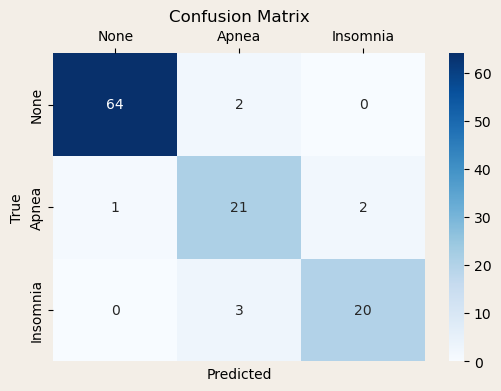

In [24]:
# Retrive best estimator from previous grid search
pipeline_rf = grid_search_rf.best_estimator_
pipeline_rf.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_rf.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Tuned SMOTE results in the same test score although a slightly different configuration in the confusion matrix: a more even "confusion" between the two positve classes rather than a dominant error in misclassifying Apnea as Insomnia.</li>
    <li>However, CV F1 score is lower than before, and train score is higher. This suggests overfitting and will justify no improvement.</li>
</ul>
</div>
